In [14]:
import numpy as np
import pandas as pd
import arviz as az
import numpyro
import numpyro.infer.initialization as init
import matplotlib.pyplot as plt

import jax
import jax.numpy as jnp
from jax import random
from numpyro.infer import MCMC, NUTS, SVI, Predictive
from numpyro.optim import Adam
from numpyro.infer.autoguide import AutoDiagonalNormal, Trace_ELBO
from numpyro.infer.reparam import CircularReparam
import numpyro.distributions as dist

from corner import corner

import os

In [2]:
data_dir = 'data/prior'
track_name = 'm1.0Y0.26FeH0.0MLT2.1ov0.003556dif1'
track_dir = os.path.join(data_dir, track_name)

track = pd.read_csv(os.path.join(track_dir, f'{track_name}.csv'))
track.head()

,filename,model_number,evol_stage,initial_mass,initial_Yinit,initial_Zinit,initial_feh,initial_MLT,initial_fov,star_mass,...,E_0_31,E_0_32,E_0_33,E_0_34,E_0_35,E_0_36,E_0_37,E_0_38,E_0_39,E_0_40
0,profile4,152,0,1.0,0.26,0.013153,0.0,2.1,0,1.0,...,1.216230e-06,0.000002,0.000006,0.000279,0.000014,0.000003,0.000002,0.000001,8.677974e-07,7.314938e-07
1,profile5,153,0,1.0,0.26,0.013153,0.0,2.1,0,1.0,...,1.070235e-06,0.000002,0.000004,0.000047,0.000027,0.000004,0.000002,0.000001,8.865659e-07,7.333283e-07
2,profile6,154,0,1.0,0.26,0.013153,0.0,2.1,0,1.0,...,9.770822e-07,0.000002,0.000003,0.000022,0.000059,0.000005,0.000002,0.000001,9.058076e-07,7.371980e-07
3,profile7,155,0,1.0,0.26,0.013153,0.0,2.1,0,1.0,...,9.140089e-07,0.000001,0.000003,0.000014,0.000159,0.000006,0.000002,0.000001,9.237271e-07,7.414930e-07
4,profile8,156,0,1.0,0.26,0.013153,0.0,2.1,0,1.0,...,8.694409e-07,0.000001,0.000002,0.000010,0.000672,0.000007,0.000002,0.000001,9.400169e-07,7.457830e-07


In [3]:
model_number = 708
profile = track.loc[track['model_number']==model_number].iloc[0]

In [4]:
n = np.arange(10, 30)
nu_index = [f'nu_0_{i}' for i in n]

def get_nu(profile):
    nu = profile[nu_index].to_numpy().astype(float)
    nu = nu[nu > 0.0]  # Values equal to zero correspond to no calculation
    return nu

nu = get_nu(profile)

In [5]:
# Scaling relation nu_max
nu_max_sca = profile['nu_max']
print('nu_max ~', round(nu_max_sca, 2), 'muHz')

# Delta_nu fit to radial modes about nu_max
delta_nu_sca = profile['delta_nu']
print('delta_nu ~', round(delta_nu_sca, 2), 'muHz')

nu_max ~ 3246.74 muHz
delta_nu ~ 146.6 muHz


Text(0, 0.5, 'nu mod. 140.74 muHz')

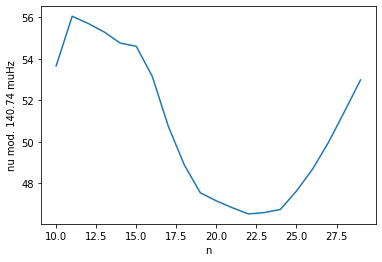

In [10]:
f = 0.96
delta_nu = f*delta_nu_sca
plt.plot(n, nu%delta_nu)
plt.xlabel('n')
plt.ylabel(f'nu mod. {delta_nu:.2f} muHz')

## Simple asymptotics

In [17]:
def linear_model(n, nu=None, nu_err=None):
    delta_nu = numpyro.sample('delta_nu', dist.Normal(140.74, 1.0))
    epsilon = numpyro.sample('epsilon', dist.Normal(1.2, 0.5))
    sigma = numpyro.sample('sigma', dist.HalfNormal(1.0))
    noise = numpyro.sample('noise', dist.HalfNormal(0.1), obs=nu_err)
    
    loc = delta_nu * (n + epsilon)
    scale = jnp.sqrt(sigma**2 + noise**2)
    
    numpyro.sample('nu', dist.Normal(loc, scale), obs=nu)

In [19]:
# n_pred = np.linspace(n.min(), n.max(), 250)

rng_key = random.PRNGKey(0)

prior_predictive = Predictive(linear_model, num_samples=1000)
prior_pred = prior_predictive(rng_key, n)

In [22]:
prior_pred['nu'].mean(axis=0)

AttributeError: 'DeviceArray' object has no attribute 'mena'